# Product Ranking System for Amazon Sports & Outdoors

In [1]:
# Libraries
import pandas as pd
import numpy as np
from pandas import json_normalize
from collections import Counter
from pandas import DataFrame
import re, ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import time
from surprise import Dataset, Reader, SVD 

# No column view limit
pd.set_option('display.max_columns', None)

### Ingest Data

In [2]:
# Import
five_core = pd.read_csv("Sports_and_OutDoors_5core.csv")
meta = pd.read_json("meta_Sports_and_OutDoors.jsonl", lines=True)
reviews = pd.read_json("Sports_and_OutDoors.jsonl", lines=True)
print("Done")

Done


### Extract Relevant Columns and Merge Data

In [3]:
#============================================
# Filter and merge relevant columns

# Keep only user ids from 5 core for most relevant reviews
five_core = five_core[["user_id"]]

# Remove duplicate ids
five_core = five_core.drop_duplicates()

# Create a column of image counts associated with review
reviews["review_image_count"] = reviews["images"].apply(lambda x: len(x) if isinstance(x, list) else 0)
reviews["review_has_images"] = reviews["review_image_count"] > 0

# Filter for relevant columns, removed asin and images(replaced with counts)
reviews = reviews[["rating", "title", "text", "parent_asin", "timestamp", "helpful_vote",
                   "verified_purchase", "user_id", "review_image_count", "review_has_images"]]
reviews = reviews.rename(columns={"title": "review_title"})

# Merge & create columns of user/item counts
df = five_core.merge(reviews, on="user_id", how="inner")
user_review_count = df["user_id"].value_counts()
item_review_count = df["parent_asin"].value_counts()

# Create a column of image counts associated with product
meta["product_images_count"] = meta["images"].apply(lambda x: len(x) if isinstance(x, list) else 0)
meta["product_has_images"] = meta["product_images_count"] > 0

meta["product_videos_count"] = meta["videos"].apply(lambda x: len(x) if isinstance(x, list) else 0)
meta["product_has_videos"] = meta["product_videos_count"] > 0

# Filter for relevant columns
meta = meta[["title", "average_rating", "rating_number", "price", "parent_asin",
             "categories", "product_images_count", "product_has_images",
             "product_videos_count", "product_has_videos",  "details"]]
df = df.merge(meta, on="parent_asin", how="left")

# Convert price column type
df["price"] = df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Clear memory
meta = None
reviews = None
five_core = None

print("Merged")

# Save as csv 
df.to_csv("sports_merged_uncleaned.csv", index=False)
print()
print("Saved")

Merged

Saved


### Examine Data

In [4]:
print("Raw size: ",df.shape)
print()
print(df.info())
print()
print(f"Numerical Summary Stats: \n{df.describe().round(2)}")
print()
df.head()

Raw size:  (4238395, 20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238395 entries, 0 to 4238394
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   user_id               object        
 1   rating                int64         
 2   review_title          object        
 3   text                  object        
 4   parent_asin           object        
 5   timestamp             datetime64[ns]
 6   helpful_vote          int64         
 7   verified_purchase     bool          
 8   review_image_count    int64         
 9   review_has_images     bool          
 10  title                 object        
 11  average_rating        float64       
 12  rating_number         int64         
 13  price                 float64       
 14  categories            object        
 15  product_images_count  int64         
 16  product_has_images    bool          
 17  product_videos_count  int64         
 18  product_has_vide

,user_id,rating,review_title,text,parent_asin,timestamp,helpful_vote,verified_purchase,review_image_count,review_has_images,title,average_rating,rating_number,price,categories,product_images_count,product_has_images,product_videos_count,product_has_videos,details
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,5,Best saddle pads,Huge fan of B Vertigo and this dressage pad do...,B0957WLR63,2022-05-26 01:01:59.105,0,True,0,False,B Vertigo Zurich Quilted Quick-Dry Dust-Resist...,5.0,3,79.99,"[Sports & Outdoors, Sports, Other Sports, Eque...",5,True,0,False,{'Item Package Dimensions L x W x H': '20.67 x...
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,5,Perfect repair kit,"I have a great Weaver halter. Recently, the Ch...",B00IET8S80,2021-07-26 20:21:51.189,0,True,0,False,"Weaver Leather Breakaway Fuse (3-Pack) , Brown",4.7,430,NaN,"[Sports & Outdoors, Sports & Outdoors Low Retu...",1,True,0,False,{'Item Package Dimensions L x W x H': '9.33 x ...
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,5,Works great,This was great for a slightly too-short girth!...,B01C2SW7XA,2021-04-07 21:43:31.976,0,True,0,False,Paris Tack English Leather Elastic Girth Exten...,4.3,40,22.95,"[Sports & Outdoors, Sports, Other Sports, Eque...",4,True,0,False,{'Item Package Dimensions L x W x H': '15.98 x...
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,5,Great stirrups with bar none grip,"I have to say, the grip on these are pretty gr...",B09NQK7MH9,2021-02-10 14:02:26.894,0,True,1,True,COMPOSITI Reflex 3D Wide Track Stirrups,4.6,276,NaN,"[Sports & Outdoors, Sports, Other Sports, Eque...",3,True,1,True,{'Item Package Dimensions L x W x H': '7.4 x 6...
4,AGGZ357AO26RQZVRLGU4D4N52DZQ,5,Perfect,Perfect for my boy! He looks adorable in it an...,B01DFBQEKA,2021-01-31 20:57:44.309,0,True,1,True,Weaver Leather Padded Breakaway Adjustable Chi...,4.6,681,25.87,"[Sports & Outdoors, Sports, Other Sports, Eque...",1,True,0,False,{'Item Package Dimensions L x W x H': '10.8 x ...


### Clean Data

In [5]:
#============================================
# Extract keys likely to be important from "details" and flatten to column

# Detail columns to keep 
keep = ["Manufacturer", "Brand", "Brand Name",  "Country of Origin", "Best Sellers Rank", 
        "Is Discontinued By Manufacturer", "Sport Type", "Sport"]

# Flatten one row at a time to use less memory (pandas was crashing)
flat_rows = []
for _, row in df.iterrows():
    d = row["details"] or {}
    clean = {k: d.get(k, None) for k in keep}
    flat_rows.append(clean)

# Adds new columns to df
flat = DataFrame(flat_rows)
for col in keep:
    df[col] = flat[col]

# Drop old details column, irrelevant now
df = df.drop(columns=["details"])

# Clear memory
flat_rows = None

#============================================
# Create a hierarchy to combine redundant columns 

# Priority: Manufacturer → Brand → Brand Name
df["Manufacturer"] = (df["Manufacturer"].fillna(df["Brand"]).fillna(df["Brand Name"]))
# Priority: Sport Type → Sport
df["Sport"] = (df["Sport Type"].fillna(df["Sport"]))

# Bad strings to NA
df["Manufacturer"] = df["Manufacturer"].replace(["None", "nan", "null"], pd.NA)
df["Sport"] = df["Sport"].replace(["None", "nan", "null"], pd.NA)

# Drop old columns
df = df.drop(columns=["Sport Type", "Brand", "Brand Name"])

#============================================
# Possibly useful columns

# Create text length columns
df['review_length'] = df['text'].astype(str).str.len()
df['title_length'] = df['review_title'].astype(str).str.len()

# Create review count columns
df['user_review_count'] = df.groupby('user_id')['user_id'].transform('count')
df['item_review_count'] = df.groupby('parent_asin')['parent_asin'].transform('count')

# Create column to measure how much user's rating differs from avg
df['rating_deviation'] = df['rating'] - df['average_rating']

# Extract dates
df['review_date'] = pd.to_datetime(df['timestamp']).dt.date
df['review_year'] = pd.to_datetime(df['timestamp']).dt.year
df['review_month'] = pd.to_datetime(df['timestamp']).dt.to_period('M')

# Days since review (useful for time-decay weighting)
max_date = df['timestamp'].max()
df['days_since_review'] = (max_date - df['timestamp']).dt.days

#============================================
# Convert column types and parse

# Price to float
df["price"] = (df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True))
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Extracting the rank as a number
if df["Best Sellers Rank"].notna().sum() > 0:
    df["best_sports_rank"] = (df["Best Sellers Rank"].astype(str).str.extract(r"(\d+)", expand=False))
    df["best_sports_rank"] = pd.to_numeric(df["best_sports_rank"], errors="coerce")

# Convert to list
df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Extract main category 
df['main_category'] = df['categories'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)
# Extract subcategory 
df['sub_category'] = df['categories'].apply(lambda x: x[2] if isinstance(x, list) and len(x) > 2 else None)

#Verify
df.head(1)

,user_id,rating,review_title,text,parent_asin,timestamp,helpful_vote,verified_purchase,review_image_count,review_has_images,title,average_rating,rating_number,price,categories,product_images_count,product_has_images,product_videos_count,product_has_videos,Manufacturer,Country of Origin,Best Sellers Rank,Is Discontinued By Manufacturer,Sport,review_length,title_length,user_review_count,item_review_count,rating_deviation,review_date,review_year,review_month,days_since_review,best_sports_rank,main_category,sub_category
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,5,Best saddle pads,Huge fan of B Vertigo and this dressage pad do...,B0957WLR63,2022-05-26 01:01:59.105,0,True,0,False,B Vertigo Zurich Quilted Quick-Dry Dust-Resist...,5.0,3,79.99,"[Sports & Outdoors, Sports, Other Sports, Eque...",5,True,0,False,Equinavia,None,"{'Sports & Outdoors': 983262, 'Equestrian Sadd...",None,None,154,16,8,1,0.0,2022-05-26,2022,2022-05,473,983262.0,Sports,Other Sports


In [6]:
#============================================
# Extract product names from title column

# Function to extract product name
def extract_product_name(row):
    title = row["title"]
    brand = row["Manufacturer"]
    
    if not isinstance(title, str):
        return pd.NA
        
    t = title.strip()
    # Remove brand if it’s there
    if isinstance(brand, str):
        pattern = re.compile(r'^' + re.escape(brand) + r'\s+', flags=re.IGNORECASE)
        t = pattern.sub('', t)
    # Cut at first " for ", comma, dash or colon
    t = re.split(r" for |,| - |:|\(", t, maxsplit=1)[0]
    
    return t.strip()

df["product_name"] = df.apply(extract_product_name, axis=1)
df[["title", "Manufacturer", "product_name"]].head(5)

,title,Manufacturer,product_name
0,B Vertigo Zurich Quilted Quick-Dry Dust-Resist...,Equinavia,B Vertigo Zurich Quilted Quick-Dry Dust-Resist...
1,"Weaver Leather Breakaway Fuse (3-Pack) , Brown","Weaver Leather, LLC",Weaver Leather Breakaway Fuse
2,Paris Tack English Leather Elastic Girth Exten...,Derby Originals,Paris Tack English Leather Elastic Girth Extender
3,COMPOSITI Reflex 3D Wide Track Stirrups,ERS,COMPOSITI Reflex 3D Wide Track Stirrups
4,Weaver Leather Padded Breakaway Adjustable Chi...,"Weaver Leather, LLC",Weaver Leather Padded Breakaway Adjustable Chi...


In [7]:
#============================================
# Count Duplicates

print("Duplicates: ",df.duplicated(subset=["user_id", "parent_asin"]).sum())
# Drop
df = df.drop_duplicates(subset=["user_id", "parent_asin"])
print("\nDuplicates Deleted")

Duplicates:  42338

Duplicates Deleted


In [23]:
#============================================
# Most likely to be useful columns

useful_cols = ['user_id', 'parent_asin', 'rating', 'text', 'review_title', 'verified_purchase', 'rating_deviation',
               'average_rating', 'rating_number', 'price', 'main_category', 'sub_category', 'product_name', 
               'helpful_vote', 'Sport', 'review_date', 'review_year', 'review_month', 'days_since_review', 
               'user_review_count', 'item_review_count', 'review_length', 'title_length']
df_cleaned = df[useful_cols].copy()

# Size of cleaned dataset
print("Cleaned size: ",df_cleaned.shape) 

Cleaned size:  (4196057, 23)


In [9]:
#============================================
# Save as csv

df_cleaned.to_csv("sports_cleaned.csv", index=False)
print("Saved")
print()
# Load csv 
#df_cleaned = pd.read_csv("sports_cleaned.csv")
#print("Loaded")
#print()
df_cleaned.info()

Saved

<class 'pandas.core.frame.DataFrame'>
Index: 4196057 entries, 0 to 4238394
Data columns (total 23 columns):
 #   Column             Dtype    
---  ------             -----    
 0   user_id            object   
 1   parent_asin        object   
 2   rating             int64    
 3   text               object   
 4   review_title       object   
 5   verified_purchase  bool     
 6   rating_deviation   float64  
 7   average_rating     float64  
 8   rating_number      int64    
 9   price              float64  
 10  main_category      object   
 11  sub_category       object   
 12  product_name       object   
 13  helpful_vote       int64    
 14  Sport              object   
 15  review_date        object   
 16  review_year        int32    
 17  review_month       period[M]
 18  days_since_review  int64    
 19  user_review_count  int64    
 20  item_review_count  int64    
 21  review_length      int64    
 22  title_length       int64    
dtypes: bool(1), float64(3), int32(

## EDA

Unique users: 409772
Max reviews per user: 844
Users with 100+ reviews: 451
Unique items: 649565
Products with <5 reviews: 493330
rating
1    0.050
2    0.037
3    0.070
4    0.154
5    0.689
Name: proportion, dtype: float64 



main_category
Sports                                       1578961
Hunting & Fishing                             855746
Outdoor Recreation                            738107
Exercise & Fitness                            461924
Fan Shop                                      215169
Sports & Outdoor Recreation Accessories       192066
Clothing                                       24134
Sports Medicine                                 8785
Memorabilia Display & Storage                   4517
Field, Court & Rink Equipment                   3591
Shooting                                        3455
Hunting & Fishing Promotion                     2356
Spring into Sports | Amazon.com                 1672
Sports & Outdoors Low Return Rate Alert 1       1641
Citi Free Shipping Promotion                    1154
Tennis & Racket                                 1093
Water Sports                                     969
Athletic Socks                                   784
Winter Storm Preparation        

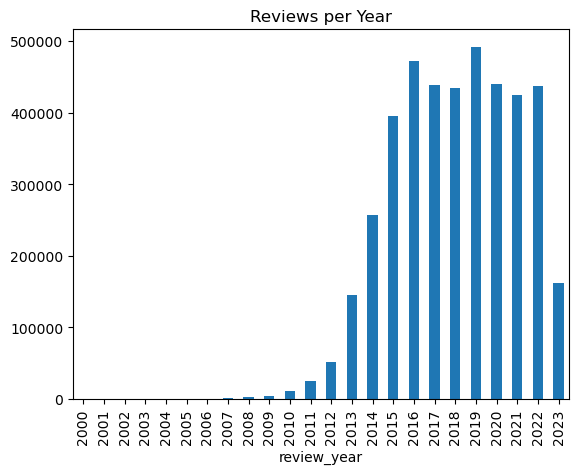

In [10]:
#============================================
# Check users with suspiciously high review counts (possible bots/spam)

user_counts = df_cleaned['user_id'].value_counts()
print(f"Unique users: {df_cleaned["user_id"].nunique()}")
print(f"Max reviews per user: {user_counts.max()}")
print(f"Users with 100+ reviews: {(user_counts >= 100).sum()}")


#============================================
# Similarly for products with very few reviews

item_counts = df_cleaned['parent_asin'].value_counts()
print(f"Unique items: {df_cleaned["parent_asin"].nunique()}")
print(f"Products with <5 reviews: {(item_counts < 5).sum()}")


#============================================
# Distributions

# Rating distribution
print(df_cleaned['rating'].value_counts(normalize=True).sort_index().round(3),"\n")

# Reviews over time
df_cleaned.groupby('review_year').size().plot(kind='bar', title='Reviews per Year')

# Category distribution
df_cleaned['main_category'].value_counts().head(20)

SPARSITY ANALYSIS
Total Users: 409,772
Total Items: 649,565
Total Ratings: 4,196,057
Sparsity: 99.998424%
Density: 0.001576%

REVIEWS PER USER:
count    4196057
mean          19
std           30
min            5
25%            7
50%           11
75%           19
max          858
Name: user_review_count, dtype: int64

REVIEWS PER ITEM:
count    4196057
mean         130
std          328
min            1
25%            8
50%           28
75%          108
max         4584
Name: item_review_count, dtype: int64



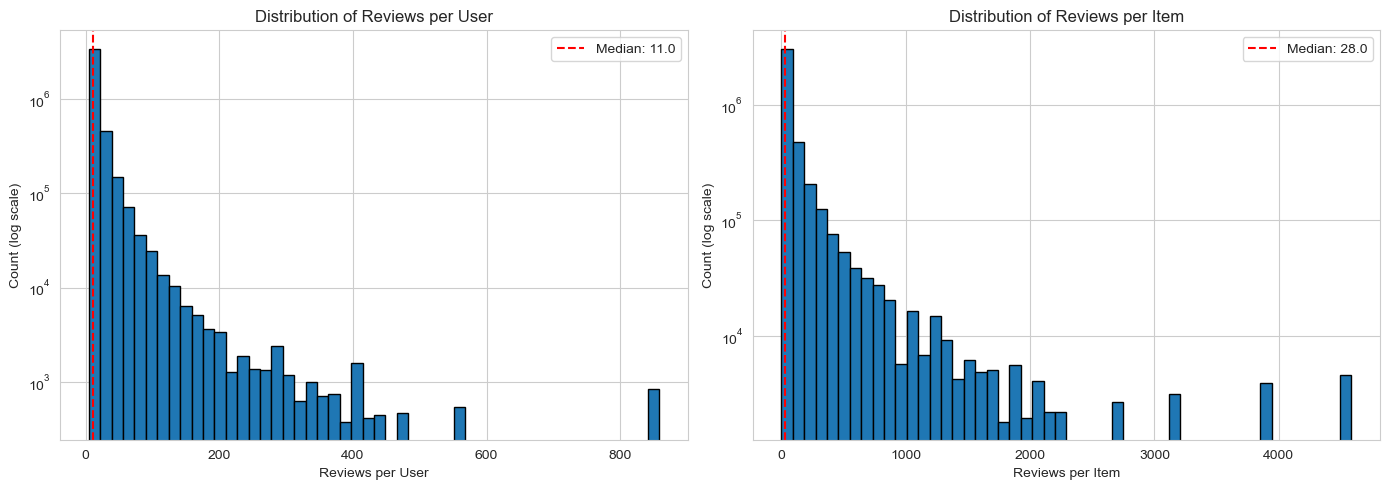

In [11]:
#============================================
# Sparsity Analysis

# User and item ratings
user_count = df_cleaned['user_id'].nunique()
item_count = df_cleaned['parent_asin'].nunique()
rating_count = len(df_cleaned)
sparsity = 1 - (rating_count / (user_count * item_count))

print("="*20)
print("SPARSITY ANALYSIS")
print("="*20)
print(f"Total Users: {user_count:,}")
print(f"Total Items: {item_count:,}")
print(f"Total Ratings: {rating_count:,}")
print(f"Sparsity: {sparsity:.6%}")
print(f"Density: {(1-sparsity):.6%}")
print()

# Distribution of reviews per user
print("REVIEWS PER USER:")
print(df_cleaned['user_review_count'].describe().round(0).astype(int))
print()

# Distribution of reviews per item
print("REVIEWS PER ITEM:")
print(df_cleaned['item_review_count'].describe().round(0).astype(int))
print()

# Plot styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User review distribution (log scale for better visualization)
axes[0].hist(df_cleaned['user_review_count'], bins=50, edgecolor='black', log=True)
axes[0].set_xlabel('Reviews per User')
axes[0].set_ylabel('Count (log scale)')
axes[0].set_title('Distribution of Reviews per User')
axes[0].axvline(df_cleaned['user_review_count'].median(), color='red', 
                linestyle='--', label=f'Median: {df_cleaned["user_review_count"].median()}')
axes[0].legend()

# Item review distribution (log scale)
axes[1].hist(df_cleaned['item_review_count'], bins=50, edgecolor='black', log=True)
axes[1].set_xlabel('Reviews per Item')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_title('Distribution of Reviews per Item')
axes[1].axvline(df_cleaned['item_review_count'].median(), color='red', 
                linestyle='--', label=f'Median: {df_cleaned["item_review_count"].median()}')
axes[1].legend()

plt.tight_layout()
plt.show()

QUALITY INDICATORS

RATING BY VERIFIED PURCHASE:
                    mean    count    std
verified_purchase                       
False              4.350   467595  1.084
True               4.402  3728462  1.097

Verified purchases: 3,728,462 (88.9%)
Unverified purchases: 467,595 (11.1%)

AVERAGE REVIEW LENGTH BY RATING:
rating
1    280.81
2    333.93
3    327.78
4    328.97
5    214.12
Name: review_length, dtype: float64

HELPFUL VOTES STATS:
count    4196057.00
mean           1.26
std           14.23
min            0.00
25%            0.00
50%            0.00
75%            1.00
max         9597.00
Name: helpful_vote, dtype: float64

Reviews with 0 helpful votes: 3,089,349 (73.6%)
Reviews with 1+ helpful votes: 1,106,708 (26.4%)
Reviews with 10+ helpful votes: 90,494 (2.2%)



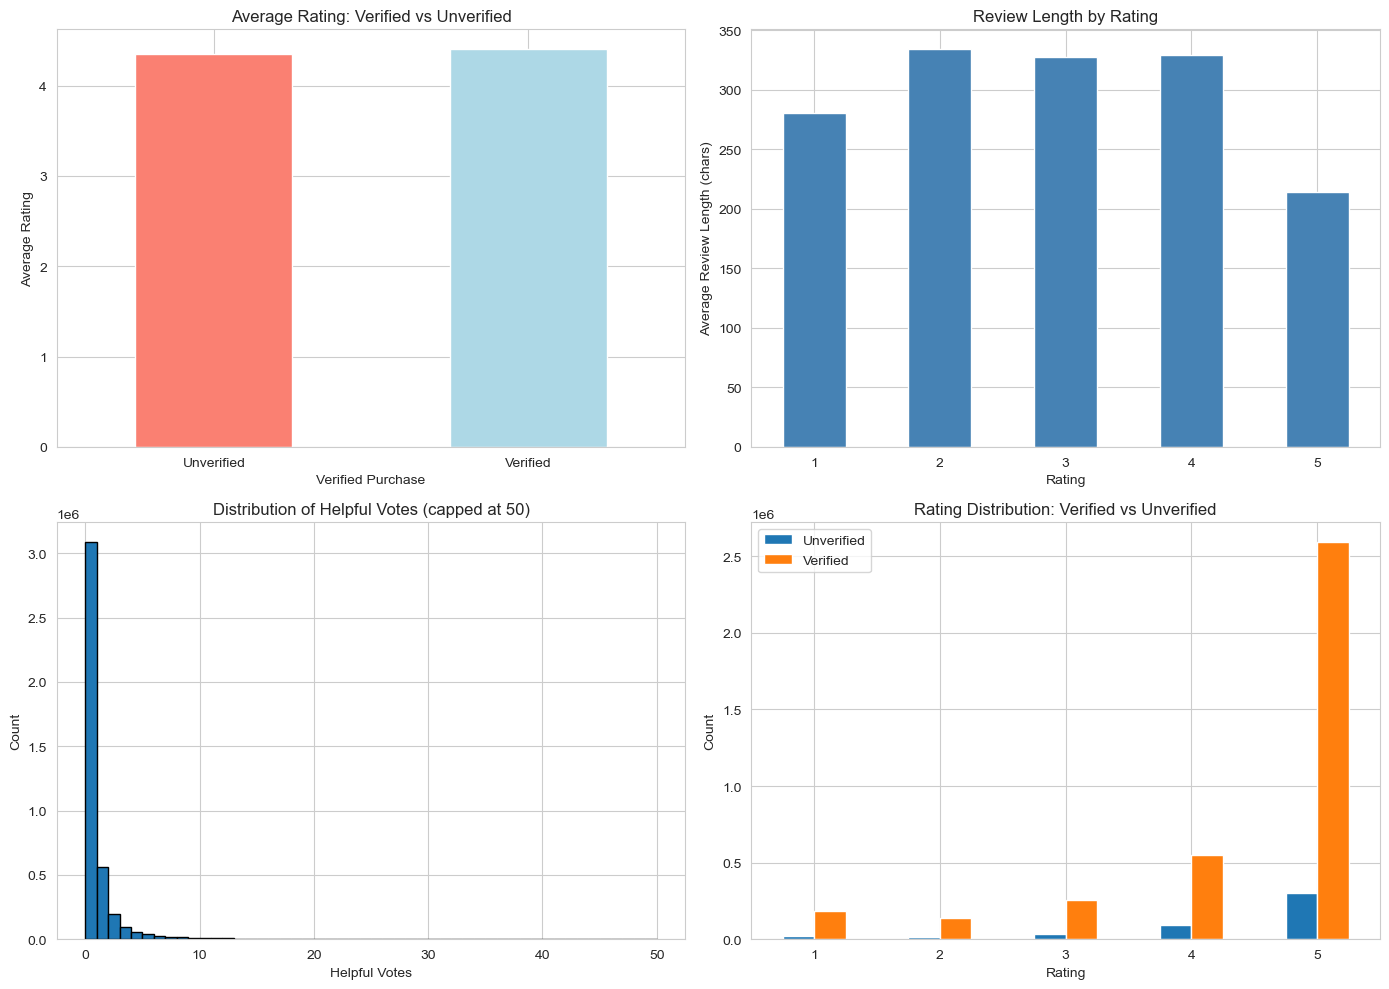

In [12]:
#============================================
# Possibly helpful indicators

print("="*20)
print("QUALITY INDICATORS")
print("="*20)

# Verified vs unverified purchases
print("\nRATING BY VERIFIED PURCHASE:")
verified_stats = df_cleaned.groupby('verified_purchase')['rating'].agg(['mean', 'count', 'std'])
print(verified_stats.round(3))
print()

# Verified purchase distribution
print(f"Verified purchases: {df_cleaned['verified_purchase'].sum():,} ({df_cleaned['verified_purchase'].mean()*100:.1f}%)")
print(f"Unverified purchases: {(~df_cleaned['verified_purchase']).sum():,} ({(~df_cleaned['verified_purchase']).mean()*100:.1f}%)")
print()

# Review length vs rating
print("AVERAGE REVIEW LENGTH BY RATING:")
length_by_rating = df_cleaned.groupby('rating')['review_length'].mean().round(2)
print(length_by_rating)
print()

# Helpful votes analysis
print("HELPFUL VOTES STATS:")
print(df_cleaned['helpful_vote'].describe().round(2))
print(f"\nReviews with 0 helpful votes: {(df_cleaned['helpful_vote'] == 0).sum():,} ({(df_cleaned['helpful_vote'] == 0).mean()*100:.1f}%)")
print(f"Reviews with 1+ helpful votes: {(df_cleaned['helpful_vote'] > 0).sum():,} ({(df_cleaned['helpful_vote'] > 0).mean()*100:.1f}%)")
print(f"Reviews with 10+ helpful votes: {(df_cleaned['helpful_vote'] >= 10).sum():,} ({(df_cleaned['helpful_vote'] >= 10).mean()*100:.1f}%)")
print()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rating by verified purchase
verified_stats['mean'].plot(kind='bar', ax=axes[0,0], color=['salmon', 'lightblue'])
axes[0,0].set_xlabel('Verified Purchase')
axes[0,0].set_ylabel('Average Rating')
axes[0,0].set_title('Average Rating: Verified vs Unverified')
axes[0,0].set_xticklabels(['Unverified', 'Verified'], rotation=0)

# 2. Review length by rating
length_by_rating.plot(kind='bar', ax=axes[0,1], color='steelblue')
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('Average Review Length (chars)')
axes[0,1].set_title('Review Length by Rating')
axes[0,1].set_xticklabels(length_by_rating.index, rotation=0)

# 3. Helpful votes distribution (cap at 50 for visualization)
df_cleaned[df_cleaned['helpful_vote'] <= 50]['helpful_vote'].hist(bins=50, ax=axes[1,0], edgecolor='black')
axes[1,0].set_xlabel('Helpful Votes')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Distribution of Helpful Votes (capped at 50)')

# 4. Rating distribution by verified purchase
df_cleaned.groupby(['verified_purchase', 'rating']).size().unstack().T.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_xlabel('Rating')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Rating Distribution: Verified vs Unverified')
axes[1,1].legend(['Unverified', 'Verified'])
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

RATING PATTERNS

RATING DEVIATION STATS:
count    4196057.000
mean           0.015
std            1.069
min           -4.000
25%           -0.300
50%            0.400
75%            0.600
max            4.000
Name: rating_deviation, dtype: float64

RATING AGREEMENT:
Users rating higher than avg: 2,911,357 (69.4%)
Users rating same as avg: 114,842 (2.7%)
Users rating lower than avg: 1,169,858 (27.9%)

PRICE ANALYSIS:
Products with price data: 2,810,091 (67.0%)
Products without price: 1,385,966 (33.0%)

Price stats:
count    2810091.00
mean          47.71
std           95.31
min            0.00
25%           14.66
50%           24.53
75%           45.95
max        17514.15
Name: price, dtype: float64

PRICE VS RATING:
                price  rating  average_rating
price           1.000  -0.003          -0.026
rating         -0.003   1.000           0.218
average_rating -0.026   0.218           1.000

AVERAGE RATING BY PRICE RANGE:
            mean    count
price_bin                
<$10  

/var/folders/ff/b7ds788x3bb79hzybxn8_qjw0000gn/T/ipykernel_14242/1819823513.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_bin_stats = df_price.groupby('price_bin')['rating'].agg(['mean', 'count'])


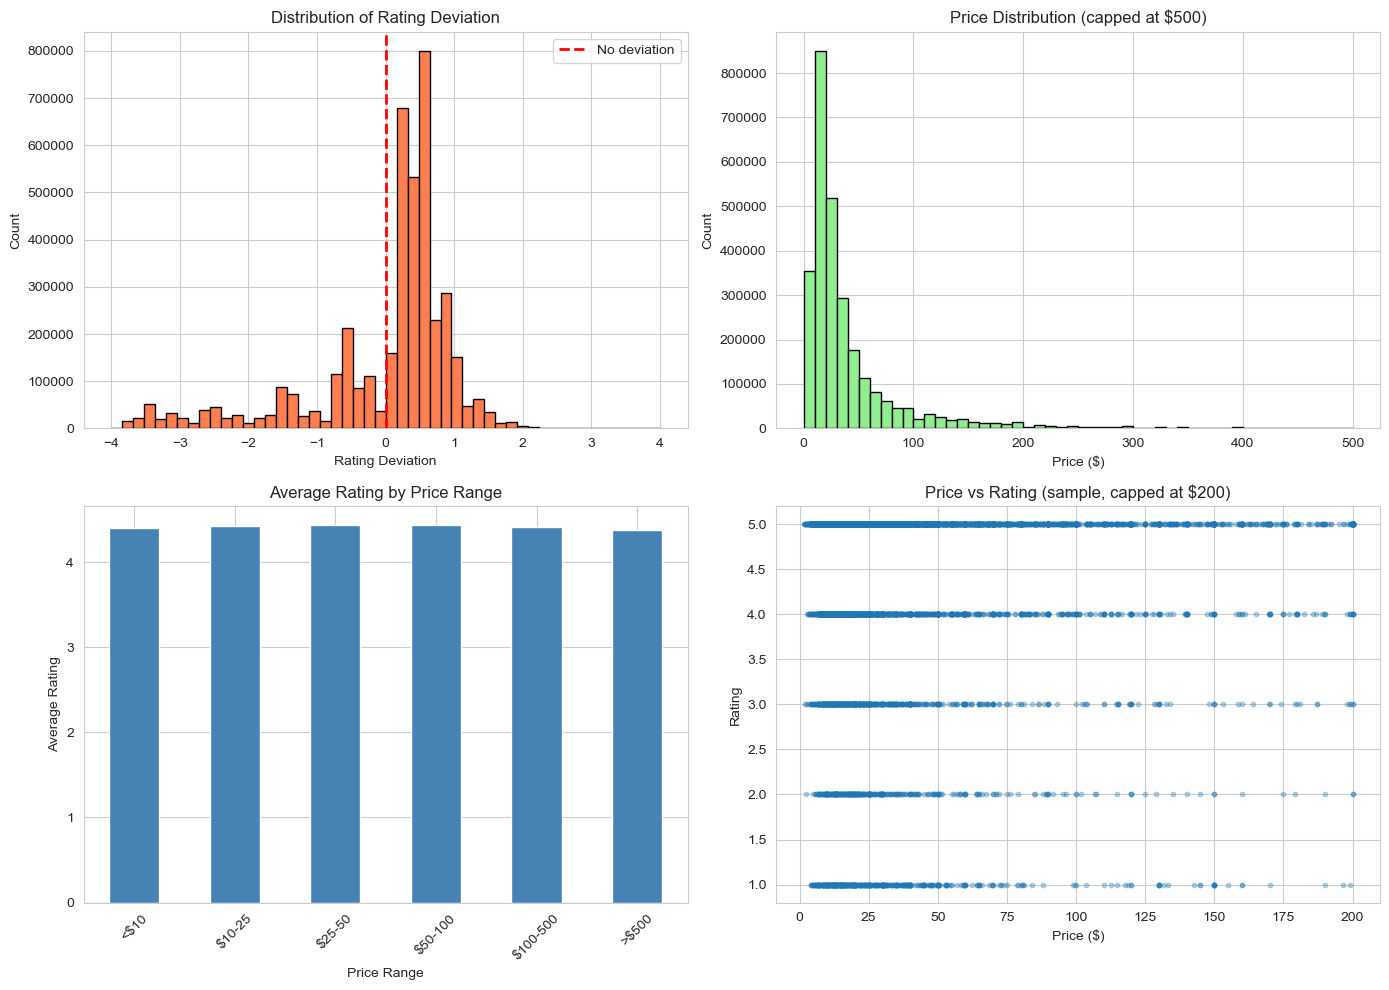

In [13]:
#============================================
# Rating & Price Analysis

print("="*20)
print("RATING PATTERNS")
print("="*20)

# Rating deviation analysis
print("\nRATING DEVIATION STATS:")
print(df_cleaned['rating_deviation'].describe().round(3))
print()

# How often do users agree with average rating?
print("RATING AGREEMENT:")
print(f"Users rating higher than avg: {(df_cleaned['rating_deviation'] > 0).sum():,} ({(df_cleaned['rating_deviation'] > 0).mean()*100:.1f}%)")
print(f"Users rating same as avg: {(df_cleaned['rating_deviation'] == 0).sum():,} ({(df_cleaned['rating_deviation'] == 0).mean()*100:.1f}%)")
print(f"Users rating lower than avg: {(df_cleaned['rating_deviation'] < 0).sum():,} ({(df_cleaned['rating_deviation'] < 0).mean()*100:.1f}%)")
print()

# Price analysis (remove NaN)
df_price = df_cleaned[df_cleaned['price'].notna()].copy()
print("PRICE ANALYSIS:")
print(f"Products with price data: {len(df_price):,} ({len(df_price)/len(df_cleaned)*100:.1f}%)")
print(f"Products without price: {df_cleaned['price'].isna().sum():,} ({df_cleaned['price'].isna().mean()*100:.1f}%)")
print()
print("Price stats:")
print(df_price['price'].describe().round(2))
print()

# Price vs rating correlation
print("PRICE VS RATING:")
price_rating_corr = df_price[['price', 'rating', 'average_rating']].corr()
print(price_rating_corr.round(3))
print()

# Rating by price bins
df_price['price_bin'] = pd.cut(df_price['price'], bins=[0, 10, 25, 50, 100, 500, 10000], 
                                 labels=['<$10', '$10-25', '$25-50', '$50-100', '$100-500', '>$500'])
print("AVERAGE RATING BY PRICE RANGE:")
price_bin_stats = df_price.groupby('price_bin')['rating'].agg(['mean', 'count'])
print(price_bin_stats.round(3))
print()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rating deviation distribution
axes[0,0].hist(df_cleaned['rating_deviation'], bins=50, edgecolor='black', color='coral')
axes[0,0].set_xlabel('Rating Deviation')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Distribution of Rating Deviation')
axes[0,0].axvline(0, color='red', linestyle='--', linewidth=2, label='No deviation')
axes[0,0].legend()

# 2. Price distribution (log scale, cap outliers)
df_price[df_price['price'] <= 500]['price'].hist(bins=50, ax=axes[0,1], edgecolor='black', color='lightgreen')
axes[0,1].set_xlabel('Price ($)')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Price Distribution (capped at $500)')

# 3. Rating by price bin
price_bin_stats['mean'].plot(kind='bar', ax=axes[1,0], color='steelblue')
axes[1,0].set_xlabel('Price Range')
axes[1,0].set_ylabel('Average Rating')
axes[1,0].set_title('Average Rating by Price Range')
axes[1,0].set_xticklabels(price_bin_stats.index, rotation=45)

# 4. Scatter: Price vs Rating (sample for performance, cap at $200)
sample_df = df_price[df_price['price'] <= 200].sample(min(10000, len(df_price)))
axes[1,1].scatter(sample_df['price'], sample_df['rating'], alpha=0.3, s=10)
axes[1,1].set_xlabel('Price ($)')
axes[1,1].set_ylabel('Rating')
axes[1,1].set_title('Price vs Rating (sample, capped at $200)')

plt.tight_layout()
plt.show()

In [14]:
print("="*20)
print("DENSE SUBSET 5+ ANALYSIS")
print("="*20)

# Create dense subset (users with 5+ reviews, items with 5+ reviews)
df_dense = df_cleaned[(df_cleaned['user_review_count'] >= 5) & (df_cleaned['item_review_count'] >= 5)].copy()

# Stats comparison
print("\nFULL DATASET:")
print(f"  Reviews: {len(df_cleaned):,}")
print(f"  Users: {df_cleaned['user_id'].nunique():,}")
print(f"  Items: {df_cleaned['parent_asin'].nunique():,}")
print(f"  Sparsity: {sparsity:.6%}")
print()

# Dense subset stats
user_count_dense = df_dense['user_id'].nunique()
item_count_dense = df_dense['parent_asin'].nunique()
sparsity_dense = 1 - (len(df_dense) / (user_count_dense * item_count_dense))

print("DENSE SUBSET (5+ reviews for users & items):")
print(f"  Reviews: {len(df_dense):,} ({len(df_dense)/len(df_cleaned)*100:.1f}% retained)")
print(f"  Users: {user_count_dense:,} ({user_count_dense/user_count*100:.1f}% retained)")
print(f"  Items: {item_count_dense:,} ({item_count_dense/item_count*100:.1f}% retained)")
print(f"  Sparsity: {sparsity_dense:.6%}")
print(f"  Sparsity improvement: {(sparsity - sparsity_dense)/sparsity*100:.2f}%")
print()

DENSE SUBSET 5+ ANALYSIS

FULL DATASET:
  Reviews: 4,196,057
  Users: 409,772
  Items: 649,565
  Sparsity: 99.998424%

DENSE SUBSET (5+ reviews for users & items):
  Reviews: 3,473,873 (82.8% retained)
  Users: 409,772 (100.0% retained)
  Items: 156,741 (24.1% retained)
  Sparsity: 99.994591%
  Sparsity improvement: 0.00%



## Modeling

In [2]:
# Load csv 
df_cleaned = pd.read_csv("sports_cleaned.csv")
print("Loaded \n")

Loaded 



In [15]:
#============================================
# Filter data for modeling

df_model = df_cleaned[['user_id', 'parent_asin', 'rating']].copy()

print(f"Total reviews: {len(df_model):,}")
print(f"Unique users: {df_model['user_id'].nunique():,}")
print(f"Unique items: {df_model['parent_asin'].nunique():,}")
print()

# TRAIN / TEST SPLIT 

# Split: 80% train, 20% test
train, val = train_test_split(df_model, test_size=0.2, random_state=22)

print(f"Train set: {len(train):,} reviews ({len(train)/len(df_model)*100:.1f}%)")
print(f"Test set: {len(val):,} reviews ({len(val)/len(df_model)*100:.1f}%)")

Total reviews: 4,196,057
Unique users: 409,772
Unique items: 649,565

Train set: 3,356,845 reviews (80.0%)
Test set: 839,212 reviews (20.0%)


In [17]:
#============================================
# Define functions for ranking metrics

# Recomending 10 items, k=10

# Precision function 
def precision_at_k(actual, predicted, user_ids, k=10, threshold=4.0):
    df = pd.DataFrame({'user_id': user_ids,
                       'actual': actual,
                       'predicted': predicted})
    
    precisions = []
    
    # Group by user
    for user_id, user_data in df.groupby('user_id'):
        top_k = user_data.nlargest(min(k, len(user_data)), 'predicted')
        relevant_in_k = (top_k['actual'] >= threshold).sum()
        precisions.append(relevant_in_k / len(top_k))
    
    return np.mean(precisions)

# Recall function 
def recall_at_k(actual, predicted, user_ids, k=10, threshold=4.0):
    df = pd.DataFrame({'user_id': user_ids,
                       'actual': actual,
                       'predicted': predicted})
    
    recalls = []
    
    # Group by user
    for user_id, user_data in df.groupby('user_id'):
        total_relevant = (user_data['actual'] >= threshold).sum()
        if total_relevant == 0:
            continue
        
        top_k = user_data.nlargest(min(k, len(user_data)), 'predicted')
        relevant_in_k = (top_k['actual'] >= threshold).sum()
        recalls.append(relevant_in_k / total_relevant)
    
    return np.mean(recalls)

# nDCG function
def ndcg_at_k(actual, predicted, user_ids, k=10):
    df = pd.DataFrame({'user_id': user_ids,
                       'actual': actual,
                       'predicted': predicted})
    ndcgs = []
    
    # Group by user 
    for user_id, user_data in df.groupby('user_id'):
        if len(user_data) < 2:
            continue
        
        k_user = min(k, len(user_data))
        
        # DCG: sort by predicted
        user_pred = user_data.nlargest(k_user, 'predicted')
        dcg = 0
        for idx, row in enumerate(user_pred.itertuples()):
            dcg += row.actual / np.log2(idx + 2)
        
        # IDCG: sort by actual
        user_ideal = user_data.nlargest(k_user, 'actual')
        idcg = 0
        for idx, row in enumerate(user_ideal.itertuples()):
            idcg += row.actual / np.log2(idx + 2)
        
        if idcg > 0:
            ndcgs.append(dcg / idcg)
    
    return np.mean(ndcgs)

# Function that delivers 5 metrics for evaluating models
def evaluate_model(actual, predicted, user_ids, model_name):
    # Calculate rmse & mae
    rmse = root_mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    
    # Calculate precision, recall
    prec = precision_at_k(actual, predicted, user_ids, k=10)
    rec = recall_at_k(actual, predicted, user_ids, k=10)
    ndcg = ndcg_at_k(actual, predicted, user_ids, k=10)
    
    print(f"\n{model_name} Metrics:\n")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Precision@10: {prec:.4f}")
    print(f"  Recall@10: {rec:.4f}")
    print(f"  nDCG@10: {ndcg:.4f}")
    
    return {'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'Precision@10': prec,
            'Recall@10': rec,
            'nDCG@10': ndcg}

print("Functions Done")

Functions Done


## Baseline models

BASELINE 1: Predict Rating with Global Average
Global average rating: 4.3961

Global Average Metrics:

  RMSE: 1.0951
  MAE: 0.8325
  Precision@10: 0.8388
  Recall@10: 0.9969
  nDCG@10: 0.9680

BASELINE 2: Predict Rating with User + Item Bias + Global Avg
User biases calculated: 409,752
Item biases calculated: 578,349

User + Item Bias Metrics:

  RMSE: 1.0846
  MAE: 0.7125
  Precision@10: 0.8390
  Recall@10: 0.9971
  nDCG@10: 0.9755

Time to Baselines: 7.99 minutes

BASELINE COMPARISON (Validation Set)
           Model     RMSE      MAE  Precision@10  Recall@10  nDCG@10
User + Item Bias 1.084582 0.712531      0.838987   0.997072 0.975518
  Global Average 1.095136 0.832486      0.838764   0.996880 0.968039



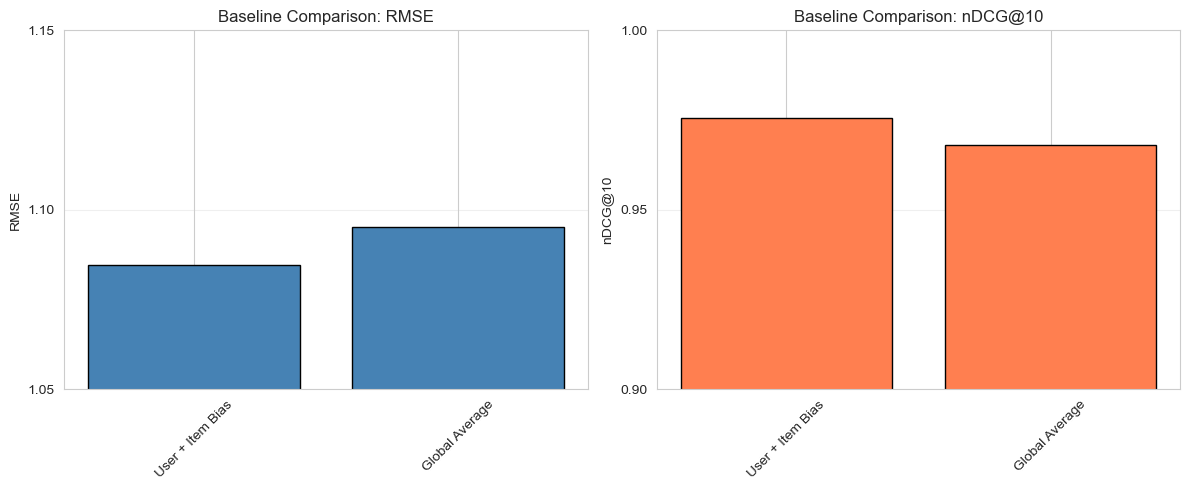

In [18]:
#============================================
# Baseline 1: Predict Rating with Global Average

print("="*60)
print("BASELINE 1: Predict Rating with Global Average")
print("="*60)

start = time.time()

# Train: calculate global average from training set
global_avg = train['rating'].mean()
print(f"Global average rating: {global_avg:.4f}")

# Test: evaluate on validation set
val_pred = np.full(len(val), global_avg)
results_global = evaluate_model(val['rating'].values, 
                                val_pred, val['user_id'].values, 
                                "Global Average")
print()

#============================================
# BASELINE 2: Predict Rating based on User + Item Bias + Global Avg

print("="*60)
print("BASELINE 2: Predict Rating with User + Item Bias + Global Avg")
print("="*60)

# Train: calculate biases from training set
user_bias = train.groupby('user_id')['rating'].mean() - global_avg
user_bias_dict = user_bias.to_dict()

item_bias = train.groupby('parent_asin')['rating'].mean() - global_avg
item_bias_dict = item_bias.to_dict()

print(f"User biases calculated: {len(user_bias_dict):,}")
print(f"Item biases calculated: {len(item_bias_dict):,}")

# Test: evaluate on validation set
val_user_bias = val['user_id'].map(user_bias_dict).fillna(0)
val_item_bias = val['parent_asin'].map(item_bias_dict).fillna(0)
val_pred = (global_avg + val_user_bias + val_item_bias).clip(1, 5).values

results_bias = evaluate_model(val['rating'].values, 
                              val_pred, val['user_id'].values, 
                              "User + Item Bias")

end = time.time()
print()
print(f"Time to Baselines: {(end - start)/60:.2f} minutes")
print()


#============================================
# BASELINE COMPARISON SUMMARY

print("="*60)
print("BASELINE COMPARISON (Validation Set)")
print("="*60)

# Combine all results
results_df = pd.DataFrame([results_global,
                           results_bias])

# Sort by nDCG@10 (primary ranking metric)
results_df = results_df.sort_values('nDCG@10', ascending=False)
print(results_df.to_string(index=False))
print()

#============================================
# VISUALIZE RESULTS

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE
axes[0].bar(results_df['Model'], results_df['RMSE'], color='steelblue', edgecolor='black')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Baseline Comparison: RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(1.05, 1.15)
axes[0].set_yticks([1.05, 1.10, 1.15])

# nDCG@10
axes[1].bar(results_df['Model'], results_df['nDCG@10'], color='coral', edgecolor='black')
axes[1].set_ylabel('nDCG@10')
axes[1].set_title('Baseline Comparison: nDCG@10')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0.90, 1.0)
axes[1].set_yticks([0.9, 0.95, 1.0])

plt.tight_layout()
plt.show()

## Advanced Models

In [19]:
#============================================
# SVD - MATRIX FACTORIZATION

print("="*60)
print("SVD - MATRIX FACTORIZATION")
print("="*60)
print()
start = time.time()

# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))

# Convert train set to Surprise format
trainset_surprise = Dataset.load_from_df(train[['user_id', 'parent_asin', 'rating']], reader).build_full_trainset()

# Initialize and train SVD
svd = SVD(n_factors=50,      # How many traits model builds
          n_epochs=20,       # How many passes to learn traits
          lr_all=0.01,       # How much to correct on learning step
          reg_all=0.02)      # Penalty for overfitting 
svd.fit(trainset_surprise)

training_time = time.time() - start
print(f"Training time: {training_time/60:.2f} minutes")
print()

# Make predictions on Validation set
start = time.time()

val_predictions = []
val_actual = val['rating'].values
val_users = val['user_id'].values

for idx, row in val.iterrows():
    pred = svd.predict(row['user_id'], row['parent_asin'], row['rating'])
    val_predictions.append(pred.est)
    
    if (idx + 1) % 100000 == 0:
        print(f"  Progress: {idx + 1:,} / {len(val):,}")

val_predictions = np.array(val_predictions)

prediction_time = time.time() - start
print(f"\nPredictions time: {prediction_time/60:.2f} minutes")
print()

# Evaluate SVD
results_svd = evaluate_model(val_actual,
                             val_predictions,
                             val_users,
                             "SVD")

eval_time = time.time() - start
print(f"\nSVD Model total time: {eval_time/60:.2f} minutes")
print()

SVD - MATRIX FACTORIZATION

Training time: 0.61 minutes

  Progress: 1,000,000 / 839,212
  Progress: 1,300,000 / 839,212
  Progress: 3,500,000 / 839,212
  Progress: 3,600,000 / 839,212
  Progress: 2,900,000 / 839,212
  Progress: 600,000 / 839,212
  Progress: 2,700,000 / 839,212

Predictions time: 0.27 minutes


SVD Metrics:

  RMSE: 1.0303
  MAE: 0.7129
  Precision@10: 0.8389
  Recall@10: 0.9970
  nDCG@10: 0.9753

SVD Model total time: 4.33 minutes



In [20]:
#============================================
# Ridge Model

start = time.time()

# Split data for Ridge
train, val = train_test_split(df_cleaned, test_size=0.2, random_state=22)

# Prepare features (NUMERIC ONLY for median)
features = ['price', 'user_review_count', 'rating_number', 'review_year', 
            'verified_purchase', 'review_length', 'title_length']

# One-hot encode
train_feat = pd.get_dummies(train[features + ['main_category', 'sub_category']], 
                             columns=['main_category', 'sub_category'], drop_first=True)
val_feat = pd.get_dummies(val[features + ['main_category', 'sub_category']], 
                          columns=['main_category', 'sub_category'], drop_first=True)

# Align columns
train_feat, val_feat = train_feat.align(val_feat, join='left', axis=1, fill_value=0)

# Fill missing (NOW it works - all numeric)
train_feat = train_feat.fillna(train_feat.median())
val_feat = val_feat.fillna(train_feat.median())

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(train_feat)
X_val = scaler.transform(val_feat)

# Train
ridge = Ridge()
ridge.fit(X_train, train['rating'].values)

# Predict and evaluate
val_pred = np.clip(ridge.predict(X_val), 1, 5)
results_ridge = evaluate_model(val['rating'].values, val_pred, val['user_id'].values, "Ridge Regression")

eval_time = time.time() - start
print(f"\nRidge Model total time: {eval_time/60:.2f} minutes")
print()


Ridge Regression Metrics:

  RMSE: 1.0851
  MAE: 0.8132
  Precision@10: 0.8381
  Recall@10: 0.9970
  nDCG@10: 0.9739

Ridge Model total time: 4.69 minutes



In [21]:
#============================================
# Hybrid Ridge and SVD

start = time.time()
# HYBRID MODEL (SVD + Ridge)
print("="*60)
print("HYBRID MODEL (SVD + Ridge)")
print("="*60)

# Get SVD predictions because ridge reused val_pred variable 
svd_pred = []
for _, row in val.iterrows():
    pred = svd.predict(row['user_id'], row['parent_asin'], row['rating'])
    svd_pred.append(pred.est)
svd_pred = np.array(svd_pred)

# Ridge predictions 
ridge_pred = val_pred  # From previous step

# Combine with weighted average
weights = [0.6, 0.4]  # 60% SVD, 40% Ridge
hybrid_pred = weights[0] * svd_pred + weights[1] * ridge_pred
hybrid_pred = np.clip(hybrid_pred, 1, 5)

# Evaluate
results_hybrid = evaluate_model(val['rating'].values,
                                hybrid_pred,
                                val['user_id'].values,
                                "Hybrid (0.6*SVD + 0.4*Ridge)")

eval_time = time.time() - start
print(f"\nHybrid Model total time: {eval_time/60:.2f} minutes")
print()

HYBRID MODEL (SVD + Ridge)

Hybrid (0.6*SVD + 0.4*Ridge) Metrics:

  RMSE: 0.7505
  MAE: 0.5540
  Precision@10: 0.8388
  Recall@10: 0.9977
  nDCG@10: 0.9981

Hybrid Model total time: 4.46 minutes



In [22]:
#============================================
# FINAL COMPARISON (All 5 Models)

comparison = pd.DataFrame([results_global,
                           results_bias,
                           results_svd,
                           results_ridge,
                           results_hybrid])

print("\n" + "="*60)
print("COMPARISON OF ALL MODELS")
print("="*60)
print(comparison.sort_values('RMSE').to_string(index=False))
print()

print("Hyrbid Model improvement over Global Avg baseline:")
best_rmse = comparison['RMSE'].min()
improvement = ((results_global['RMSE'] - best_rmse) / results_global['RMSE']) * 100
print(f"RMSE improvement: {improvement:.1f}%")

best_ndcg = comparison['nDCG@10'].max()
baseline_ndcg = results_global['nDCG@10']
improvement_ndcg = ((best_ndcg - baseline_ndcg) / baseline_ndcg) * 100
print(f"nDCG@10 improvement: {improvement_ndcg:.1f}%")


COMPARISON OF ALL MODELS
                       Model     RMSE      MAE  Precision@10  Recall@10  nDCG@10
Hybrid (0.6*SVD + 0.4*Ridge) 0.750507 0.554005      0.838813   0.997687 0.998080
                         SVD 1.030278 0.712931      0.838947   0.997027 0.975251
            User + Item Bias 1.084582 0.712531      0.838987   0.997072 0.975518
            Ridge Regression 1.085052 0.813203      0.838100   0.997010 0.973858
              Global Average 1.095136 0.832486      0.838764   0.996880 0.968039

Hyrbid Model improvement over Global Avg baseline:
RMSE improvement: 31.5%
nDCG@10 improvement: 3.1%


In [ ]:
#============================================
# Tried to implement DNN based on paper, kernal crash

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Embedding, LSTM, TextVectorization
from tensorflow.keras.models import Model

start = time.time()
df = df_sample.copy() # SAMPLED 10 PERCENT OF DATASET

# Combine text as mentioned in paper
df["full_text"] = df["text"].fillna("") + " " + df["review_title"].fillna("")
text_input = Input(shape=(1,), dtype="string")
tv = TextVectorization(max_tokens=5000, output_sequence_length=100, standardize="lower")
tv.adapt(df["full_text"])

x_text = tv(text_input)
x_text = Embedding(5000, 64)(x_text)
x_text = LSTM(32)(x_text)

# One-hot cat encoding like paper
sc = pd.get_dummies(df["Sport"].fillna("none"))
cat_input = Input(shape=(sc.shape[1],))

# Numeric feature count
num_input = Input(shape=(3,))  
num_core = df[["average_rating","rating_number","helpful_vote"]].fillna(0).values

# Merge 
merged = Concatenate()([x_text, cat_input, num_input])
x = Dense(64, "relu")(merged)
x = Dropout(0.2)(x)
x = Dense(32, "relu")(x)
o = Dense(1)(x)

m = Model([text_input, cat_input, num_input], o)
m.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss="mse")

# Train, Predict, Eval
m.fit([df["full_text"].values, sc.values, num_core], df["rating"].values, epochs=15, batch_size=256, validation_split=0.3)
p = m.predict([df["full_text"].values, sc.values, num_core]).flatten()
print("RMSE:", root_mean_squared_error(df["rating"].values, p))
res = evaluate_model(df["rating"].values, p, sc.index, "DNN_paper_style")

eval_time = time.time() - start
print(f"\nDNN total time: {eval_time/60:.2f} minutes")
print()